# **Task 5: Image Denoising in wavelet domain**

## **Team member**:  

    * BEHIDJ Ramzi *
    * Ousmane CISSE * 

In [ ]:
!wget http://hebergement.universite-paris-saclay.fr/mkowalski/AI/data/barbara.jpg
!wget https://github.com/gpeyre/numerical-tours/raw/master/python/nt_toolbox.zip
!unzip nt_toolbox.zip

# Image denoising in wavelet domain

In [2]:
import cv2
from nt_toolbox.general import *
from nt_toolbox.signal import *
from nt_toolbox.compute_wavelet_filter import *
import numpy as np
import matplotlib.pylab as plt
import scipy
from numpy import linalg


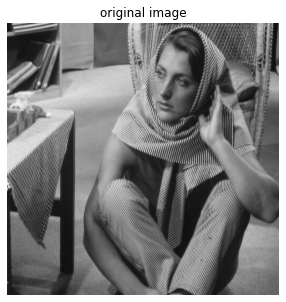

In [3]:
# input our dataset image Barbara
img = load_image('barbara.jpg')

plt.figure(figsize=(5,5));plt.axis('off');plt.title('original image')
plt.imshow(img,cmap = 'gray')
plt.show()

### Simulate a noisy version of the image using the noises at various SNR Level (0 db, 10 dB and 20 dB)

In [4]:
def compute_sigma(signal,SNR_db):
  return np.sqrt(np.sum(signal**2)/(signal.shape[0]*signal.shape[1]) / 10.0**(SNR_db/10.0))

def create_noisy_image (img,SNR_db):
  noise_img = np.copy(img)
  return noise_img + np.random.standard_normal(img.shape) * compute_sigma(img,SNR_db)

def plot_image_grille(input_vect,list_name = [], col = 2):
    nbre_img = len(input_vect)
    nbre_ligne = nbre_img//col +1
    
    fig = plt.figure(figsize=(12, 10))
    for i in range(nbre_img):
        fig.add_subplot(nbre_ligne,col,i+1)
        plt.imshow(input_vect[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
        if list_name:
          plt.title(list_name[i])
       
    plt.show()

In [5]:
SNRs = [0,10,20]
noisy_imgs_label = ['Noising image SNR =0','Noising image SNR =10','Noising image SNR =20']
NoisyImgs = [create_noisy_image (img,SNR_db) for SNR_db in SNRs]
list_sigmas = [compute_sigma (img,SNR_db) for SNR_db in SNRs]

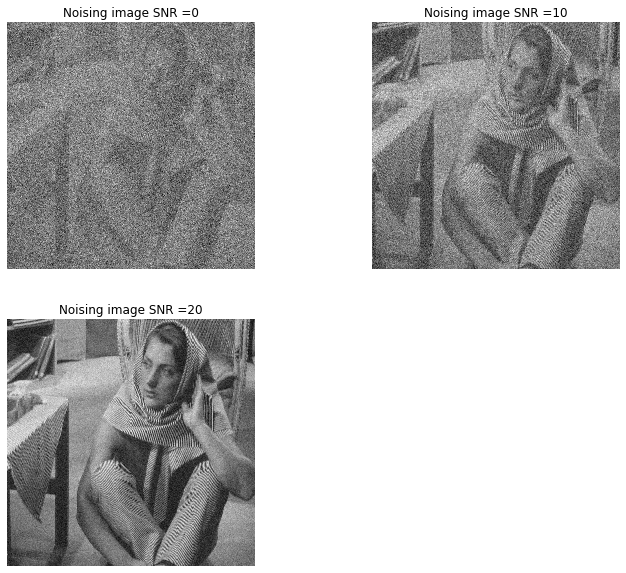

In [6]:
plot_image_grille(NoisyImgs,noisy_imgs_label,2)

### Denoise the image by performing hard thresholding and soft thresholding in the wavelet domain

In [7]:
def thresh_hard(u,t):
  return u*(abs(u)>t)

In [21]:
def hard_wavelet_trans(img,signal,sigma,h,Jmin=2,T=0,imag=False):
    # compute the wavelet coefficients a of the noisy image signal.
    a = perform_wavortho_transf(signal,Jmin,+1,h)
    # Select the threshold value, that should be proportional to the noise level σ.
    if T==0:
      T = 3*sigma
    # Hard threshold the coefficients below the noise level to obtain aT(m)=s0T(am).
    aT = thresh_hard(a,T)

    fHard = perform_wavortho_transf(aT,Jmin,-1,h)
    #Display the denoising result.
    if(imag) :
      imageplot(clamp(fHard), 'Hard, SNR=' + str(snr(img,fHard)))#str(np.log10(np.sum(img**2)/np.sum((fHard-img)**2))*10))
    else:
      return fHard,snr(img,fHard)

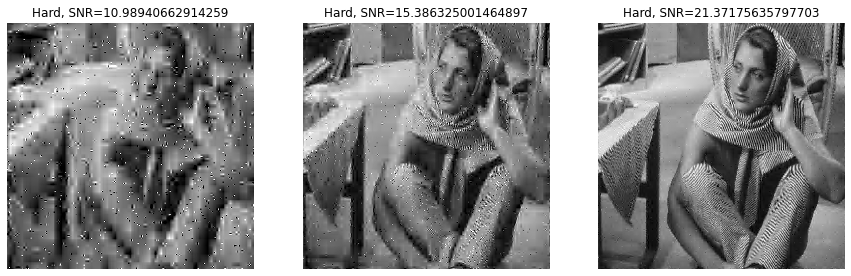

In [33]:
fig, axs = plt.subplots(nrows = 1, ncols = len(NoisyImgs), figsize = (15, 15))
for i in range(len(NoisyImgs)):
    plt.subplot(1,3,i+1)
    hard_wavelet_trans(img,NoisyImgs[i],list_sigmas[i],(compute_wavelet_filter("Daubechies",4)/np.linalg.norm(compute_wavelet_filter("Daubechies",4))),imag=True)
plt.show()

In [34]:
type_wavelet = ['Daubechies']
list_param = [1,4,6,8,10,12,14,16,18,20]

def variation_param(NoisyImgs,list_sigmas,img,type_wavelet,list_param, SNRs,hard=True,Jmin=2,col = 2):# ,noise_1_vect,music_with_noise_1_vect,music_wav):
  # Dimensionnement du plot
  nbre_ligne = len(SNRs)//col +1 
  #definition de la taille du plot
  fig = plt.figure(figsize=(12, 10))
    #Loup le long des noises
  for s in range(len(SNRs)):
    #Creation d'un plot par type
    fig.add_subplot(nbre_ligne,col,s+1)
    #Loup le long des differentes h
    distance =[]
    for y in range(len(list_param)):
      #snr ordonnée
      if hard:
        distance.append(hard_wavelet_trans(img,NoisyImgs[s],list_sigmas[s],(compute_wavelet_filter('Daubechies',list_param[y])/np.linalg.norm(compute_wavelet_filter('Daubechies',list_param[y]))),Jmin)[1])
      else:
        distance.append(soft_wavelet_trans(img,NoisyImgs[s],list_sigmas[s],(compute_wavelet_filter('Daubechies',list_param[y])/np.linalg.norm(compute_wavelet_filter('Daubechies',list_param[y]))),Jmin)[1])
    plt.plot(list_param,distance) #, label='Noising_SNR='+str(SNRs[s]))
    plt.xlabel(r'Value of Param H')
    plt.ylabel("SNR value")
    #plt.yscale('log')
    plt.title('param variation for Daubechies wavelet Noising_SNR='+str(SNRs[s]))
    #plt.legend()
  plt.show()

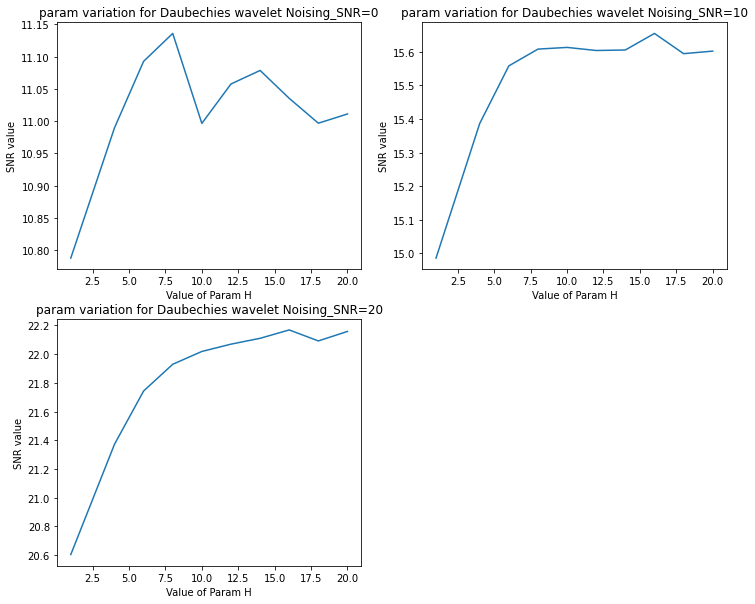

In [35]:
variation_param(NoisyImgs,list_sigmas,img,type_wavelet,list_param, SNRs,Jmin=2,col = 2)

In [36]:
def thresh_soft(u,t):
  return np.maximum(1-t/abs(u), 0)*u

def soft_wavelet_trans(img,signal,sigma,h,Jmin=2,T=0,imag=False):
    # compute the wavelet coefficients a of the noisy image signal.
    a = perform_wavortho_transf(signal,Jmin,+1,h)
    # Select the threshold.
    if T==0:
      T = 3/2*sigma
    # Perform the soft thresholding.
    aT = thresh_soft(a,T)
    # To slightly improve the soft thresholding performance, we do not threshold the coefficients corresponding to coarse scale wavelets.
    aT[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]

    # Reconstruct the soft thresholding estimator f̃.
    fSoft = perform_wavortho_transf(aT,Jmin,-1,h)
    # Display the soft thresholding denoising result.
    if(imag) :
      imageplot(clamp(fSoft), 'Soft, SNR=' + str(snr(img,fSoft)))#str(np.log10(np.sum(img**2)/np.sum((fSoft-img)**2))*10) )
    return fSoft,snr(img,fSoft)

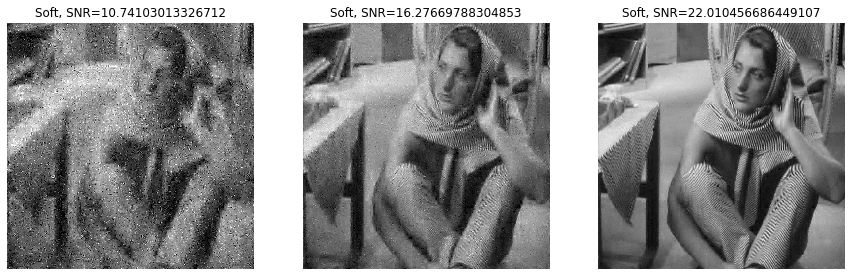

In [37]:
fig, axs = plt.subplots(nrows = 1, ncols = len(NoisyImgs), figsize = (15, 15))
for i in range(len(NoisyImgs)):
    plt.subplot(1,3,i+1)
    soft_wavelet_trans(img,NoisyImgs[i],list_sigmas[i],(compute_wavelet_filter("Daubechies",4)/np.linalg.norm(compute_wavelet_filter("Daubechies",4))),imag=True)
plt.show()

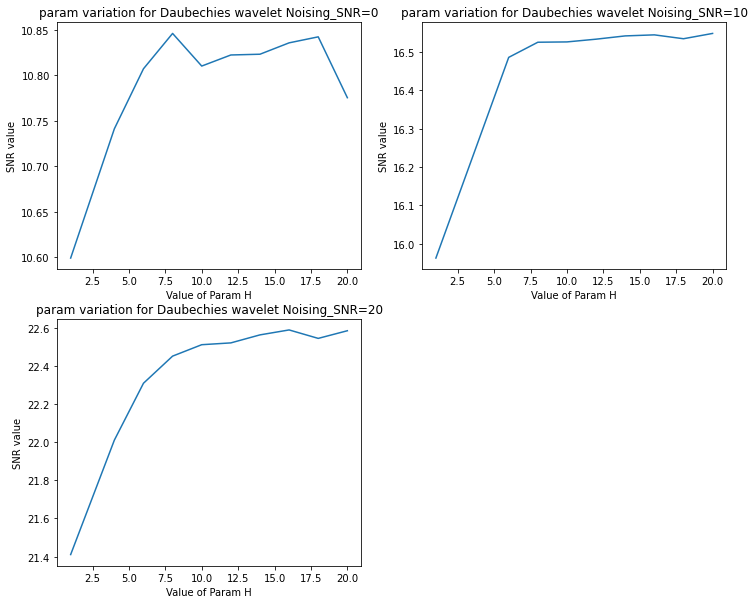

In [38]:
variation_param(NoisyImgs,list_sigmas,img,type_wavelet,list_param, SNRs,False,Jmin=2,col = 2)

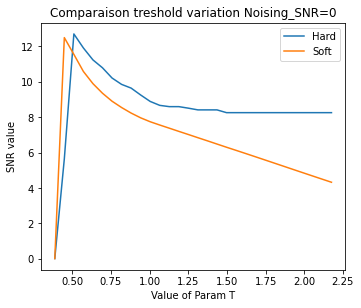

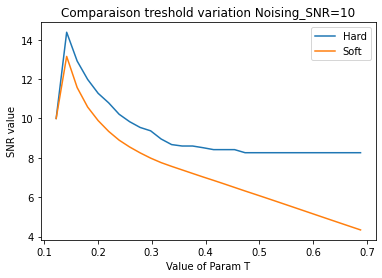

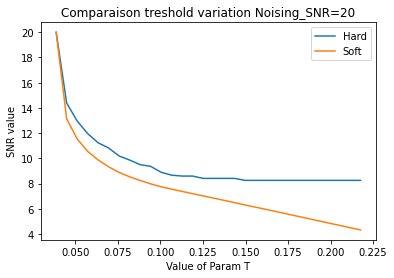

In [40]:
#Variation du T
Jmin=2
fig = plt.figure(figsize=(12, 10))
for s in range(len(SNRs)):
  hadr_tresh=[]
  soft_tresh=[]
  T = np.linspace(0.8*list_sigmas[s],4.5*list_sigmas[s],30)
  for i in range(len(T)):
    hadr_tresh.append(hard_wavelet_trans(img,NoisyImgs[s],list_sigmas[s],(compute_wavelet_filter('Daubechies',14)/np.linalg.norm(compute_wavelet_filter('Daubechies',14))),Jmin,T=[i])[1])
    soft_tresh.append(soft_wavelet_trans(img,NoisyImgs[s],list_sigmas[s],(compute_wavelet_filter('Daubechies',14)/np.linalg.norm(compute_wavelet_filter('Daubechies',14))),Jmin,T=[i])[1])

  fig.add_subplot(2,2,s+1)
  plt.plot(T,hadr_tresh,label ='Hard')
  plt.plot(T,soft_tresh,label='Soft') #, label='Noising_SNR='+str(SNRs[s]))
  plt.xlabel(r'Value of Param T')
  plt.ylabel("SNR value")
    #plt.yscale('log')
  plt.title('Comparaison treshold variation Noising_SNR='+str(SNRs[s]))
  plt.legend()
  plt.show()


### Discuss the parameters (wavelet type, number of level, type of thresholding)

We notice that the variation of the Daubechies sclaling impacts differently our noisy images, it is not easy to choose a scaling that would work well with all images whether it is with the hard or soft tresholding.

As for the variation of the alpha parameter on the two types of tresholding, we notice that whatever the noisy image, the hard tresholding gives a higher SNR value.And the increase of Jmin improves a little the snr.

### Denoise the image by implementing translation invariant wavelet transform

In [47]:
def invar_wavelet_trans(signal,sigma,m=4):
    n = signal.shape[0]
    # Generate a set of shifts (δi)i.
    [dY,dX] = np.meshgrid(np.arange(0,m),np.arange(0,m))
    delta = np.concatenate( (dX.reshape(m*m,1), dY.reshape(m*m,1)), axis=1)

    fTI = np.zeros([n,n])
    T = 3*sigma
    h=(compute_wavelet_filter("Daubechies",4)/np.linalg.norm(compute_wavelet_filter("Daubechies",4)))
    for i in np.arange(0,m*m):
        fS = circshift(signal,delta[i,:])
        a = perform_wavortho_transf(fS,Jmin,1,h)
        aT = thresh_hard(a,T)
        fS = perform_wavortho_transf(aT,Jmin,-1,h)
        fS = circshift(fS,-delta[i,:])
        fTI = i/(i+1.0)*fTI + 1.0/(i+1)*fS
    imageplot(clamp(fTI), 'TI, SNR=' + str(np.log10(np.sum(img**2)/np.sum((fTI-img)**2))*10)  )

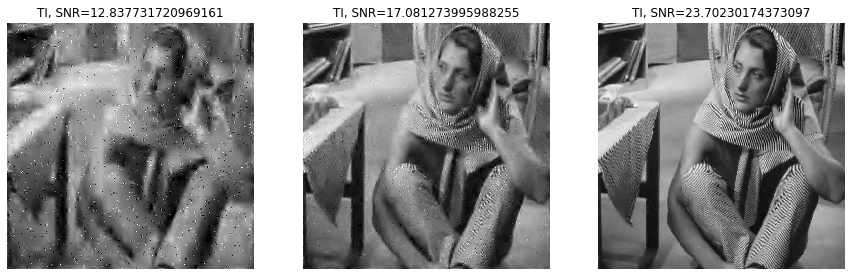

In [49]:
fig, axs = plt.subplots(nrows = 1, ncols = len(list_sigmas), figsize = (15, 15))
for i in range(len(list_sigmas)):
    plt.subplot(1,3,i+1)
    invar_wavelet_trans(NoisyImgs[i],list_sigmas[i],10)
plt.show()

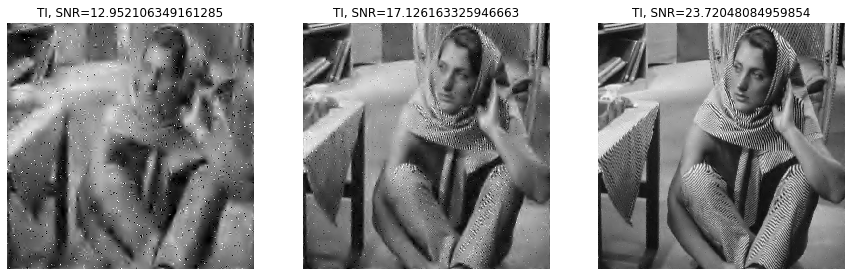

In [50]:
fig, axs = plt.subplots(nrows = 1, ncols = len(list_sigmas), figsize = (15, 15))
for i in range(len(list_sigmas)):
    plt.subplot(1,3,i+1)
    invar_wavelet_trans(NoisyImgs[i],list_sigmas[i],15)
plt.show()

We note an improvement of the snr with the increase of the parameter m.